In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial
import pickle
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import csv
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  app.launch_new_instance()


In [2]:
tfidf_path = '../../data/tfidf_merged_chs_20211216_nocrossover/'

In [3]:
# fandom_list = ['harry_potter',
#  'dcu',
#  'doctor_who_&_related_fandoms',
#  'arthurian_mythology_&_related_fandoms',
#  'supernatural',
#  'haikyuu',
#  'kuroko_no_basuke',
#  'hamilton_miranda',
#  'dragon_age_all_media_types',
#  'the_walking_dead_&_related_fandoms',
#  'buffy_the_vampire_slayer',
#  'naruto',
#  'tolkien_j_r_r_works_&_related_fandoms',
#  'hetalia_axis_powers',
#  'attack_on_titan',
#  'ms_paint_adventures',
#  'marvel',
#  'one_direction',
#  'sherlock_holmes_&_related_fandoms']

In [4]:
fandom_list = [i for i in os.listdir(tfidf_path) if 'tsv' in i]

In [5]:
fandom_list

['star_wars_all_media_types_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'buffy_the_vampire_slayer_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'doctor_who_&_related_fandoms_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'harry_potter_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'one_direction_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'the_walking_dead_&_related_fandoms_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'haikyuu_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'ms_paint_adventures_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'dcu_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'supernatural_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'kuroko_no_basuke_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'naruto_temporal_tfidf_cos_merged_chapters_20211216_no_crossover.tsv',
 'arthuri

In [6]:
def var_bootstrap_resample(li):
    if len(li) > 0:
        var_original = np.var(li)
        var_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            var_s.append(np.var(sample))
        tail = sorted(var_s)[5]
        head = sorted(var_s)[95]
        return (var_original, tail, head)

In [7]:
def ave_bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        ave_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            ave_s.append(np.average(sample))
        tail = sorted(ave_s)[5]
        head = sorted(ave_s)[95]
        return (ave_original, tail, head)

In [8]:
def create_normed_dfs(df, field):

#     turn into z scores
    df[field] = np.log(df[field]+1)
    df = df.replace([np.inf, -np.inf], np.nan)
    df[field].dropna()
    df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)

    return df

In [9]:
def create_dict(df, nov_field, suc_field, metric):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    term_n = sorted(df[nov_field].tolist())
    term_n = np.quantile(term_n, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    term_n = np.insert(term_n, 0, 0)
    term_n = np.concatenate([term_n, [1]])
    dic = {}
    for i in range(len(term_n)-1):
        df_s = df[(df[nov_field] >= term_n[i]) & (df[nov_field] < term_n[i+1])]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            if metric == 'ave':
                dic[term_n[i]] = ave_bootstrap_resample(li)
            elif metric == 'var':
                dic[term_n[i]] = var_bootstrap_resample(li)
    return dic

In [10]:
def generate_res(path, nov_field, suc_field, metric):
    df_all = []
    fandom_list = [i for i in os.listdir(path) if 'tsv' in i]
    for i,fandom in enumerate(fandom_list):
        df = pd.read_csv(os.path.join(path,fandom), sep = '\t')
        df = create_normed_dfs(df, suc_field)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[[nov_field, suc_field]].dropna()
        df_all.append(df)

    df = pd.concat(df_all)
    df = df.sort_values(by = nov_field)
    df = df.sort_values(by = suc_field)
    dic = create_dict(df, nov_field, suc_field, metric)

    return dic
    

In [11]:
def generate_save_dics(suffix='None'):
    tfidf_kudos_dict_var = generate_res(tfidf_path, 'Cos','Kudos', 'var')
    tfidf_hits_dict_var = generate_res(tfidf_path, 'Cos','Hits', 'var')
    tfidf_comments_dict_var = generate_res(tfidf_path, 'Cos','Comments', 'var')
    tfidf_bookmarks_dict_var = generate_res(tfidf_path, 'Cos','Bookmarks', 'var')
    pickle.dump(tfidf_kudos_dict_var, open('tfidf_kudos_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_hits_dict_var, open('tfidf_hits_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_comments_dict_var, open('tfidf_comments_dict_var_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_bookmarks_dict_var, open('tfidf_bookmarks_dict_var_{}.p'.format(suffix), 'wb'))
    
    tfidf_kudos_dict_ave = generate_res(tfidf_path, 'Cos','Kudos', 'ave')
    tfidf_hits_dict_ave = generate_res(tfidf_path, 'Cos','Hits', 'ave')
    tfidf_comments_dict_ave = generate_res(tfidf_path, 'Cos','Comments', 'ave')
    tfidf_bookmarks_dict_ave = generate_res(tfidf_path, 'Cos','Bookmarks', 'ave')
    pickle.dump(tfidf_kudos_dict_ave, open('tfidf_kudos_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_hits_dict_ave, open('tfidf_hits_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_comments_dict_ave, open('tfidf_comments_dict_ave_{}.p'.format(suffix), 'wb'))
    pickle.dump(tfidf_bookmarks_dict_ave, open('tfidf_bookmarks_dict_ave_{}.p'.format(suffix), 'wb'))
    


In [13]:
generate_save_dics()

In [14]:
def load_dics(suffix='None'):
    global tfidf_kudos_dict_var, tfidf_hits_dict_var, tfidf_comments_dict_var, tfidf_bookmarks_dict_var
    global tfidf_kudos_dict_ave, tfidf_hits_dict_ave, tfidf_comments_dict_ave, tfidf_bookmarks_dict_ave
    
    tfidf_kudos_dict_var = pickle.load(open('tfidf_kudos_dict_var_{}.p'.format(suffix), 'rb'))
    tfidf_hits_dict_var = pickle.load(open('tfidf_hits_dict_var_{}.p'.format(suffix), 'rb'))
    tfidf_comments_dict_var = pickle.load(open('tfidf_comments_dict_var_{}.p'.format(suffix), 'rb'))
    tfidf_bookmarks_dict_var = pickle.load(open('tfidf_bookmarks_dict_var_{}.p'.format(suffix), 'rb'))
      
    tfidf_kudos_dict_ave = pickle.load(open('tfidf_kudos_dict_ave_{}.p'.format(suffix), 'rb'))
    tfidf_hits_dict_ave = pickle.load(open('tfidf_hits_dict_ave_{}.p'.format(suffix), 'rb'))
    tfidf_comments_dict_ave = pickle.load(open('tfidf_comments_dict_ave_{}.p'.format(suffix), 'rb'))
    tfidf_bookmarks_dict_ave = pickle.load(open('tfidf_bookmarks_dict_ave_{}.p'.format(suffix), 'rb'))
    


In [15]:
load_dics()

In [16]:
tfidf_kudos_dict_var

{0.0: (0.9329566375217464, 0.9242969636448429, 0.9445416075669476),
 0.12840409458345106: (0.9056586804715193,
  0.8970903765667919,
  0.9148919502796822),
 0.16200703124927748: (0.9117434490744105,
  0.901172324520343,
  0.9194605070677587),
 0.19266450094833001: (0.9155078977221967,
  0.9068212178950752,
  0.9249577582919264),
 0.2254040217754605: (0.9456339806534599,
  0.9361703806480205,
  0.9545908855647147),
 0.2642774105439776: (0.9467701499996051,
  0.9368664763295407,
  0.9573051971163746),
 0.31090186012169485: (0.9533513508238056,
  0.9430464110902511,
  0.9621194329680334),
 0.3647085413358686: (0.9381011371754462,
  0.9286995667704997,
  0.947927006775338),
 0.4255718582023647: (0.9337843076206609,
  0.9239883882605138,
  0.9441907076546608),
 0.5054632399573804: (1.0079422563997007,
  0.9993666594219641,
  1.0169293243628712)}

In [17]:
def create_xs(keys):
    xs = []
    for i in range(len(keys)-1):
        xs.append(keys[i] + (keys[i+1] - keys[i])/2)
    return xs

In [18]:
def extract_plot_vals(dic):
    keys = sorted(dic.keys())
    keys.append(1)
    x = create_xs(keys)
    y = [dic[j][0] for j in keys[:-1]]
    lower_error = [dic[j][0] - dic[j][1] for j in keys[:-1]]
    upper_error = [dic[j][2] - dic[j][0] for j in keys[:-1]]
    asymmetric_error = [lower_error, upper_error]
    return x,y,asymmetric_error

In [19]:
x,y,e = extract_plot_vals(tfidf_kudos_dict_ave)
print(x)

[0.06420204729172553, 0.14520556291636427, 0.17733576609880375, 0.20903426136189526, 0.24484071615971903, 0.2875896353328362, 0.33780520072878173, 0.39514019976911663, 0.46551754907987253, 0.7527316199786902]


## Add heatmap

In [20]:
# df_all = []
# for i,fandom in enumerate(fandom_list):
#     df_tfidf = pd.read_csv(os.path.join(tfidf_path,fandom + '_tfidf_merged_chapters_20230115_largest_rel.tsv'), \
#                            sep = '\t',  quoting=csv.QUOTE_NONE)
#     del df_tfidf['index']
#     df_lda = pd.read_csv(os.path.join(lda_path,fandom + '_lda_with_dist_merged_chs_20230115_largest_rel.tsv'),\
#                          sep = '\t',  quoting=csv.QUOTE_NONE)
# #     df['Topic_entropy'] = df.apply(lambda row: entropy(eval(row['Dist'])), axis=1)

#     del df_lda['index']
#     df_tfidf = df_tfidf.astype('object')
#     df_lda = df_lda.astype('object')

#     #     df_tfidf['Chapters'] = df_tfidf.astype('object')
#     df = pd.merge(df_tfidf, df_lda, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks', 'Category',\
#  'Chapters' ,'Characters','Comments' ,'CompleteDate',\
#  'Fandoms', 'Hits' ,'Kudos', 'Language' ,'PublishDate' ,'Rating',\
#  'Relationship','Title' ,'URL' ,'UpdateDate' ,'Words'], how='inner')

#     df = df.replace([np.inf, -np.inf], np.nan)
#     df['Hits'].fillna(0, inplace=True)
#     df['Kudos'].fillna(0, inplace=True)
#     df['Bookmarks'].fillna(0, inplace=True)
#     df['Comments'].fillna(0, inplace=True)

#     df_all.append(df)

In [22]:
# df_all = pd.concat(df_all)

In [23]:
# df_all.head(2)

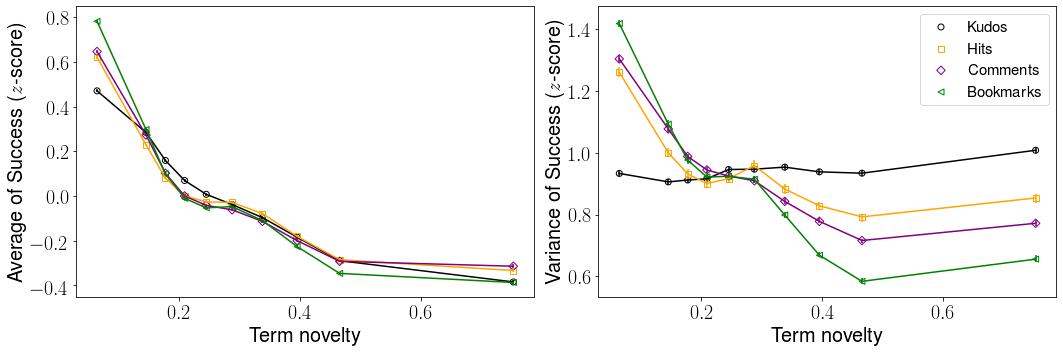

In [24]:
fig, axes = plt.subplots(1,2,figsize = (15,5))
# fig.subplots_adjust(bottom = 0.4)



x, y, err = extract_plot_vals(tfidf_kudos_dict_ave)
axes[0].errorbar(x, y, yerr=err, color='black')
axes[0].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(tfidf_hits_dict_ave)
axes[0].errorbar(x, y, yerr=err, c='orange')
axes[0].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(tfidf_comments_dict_ave)
axes[0].errorbar(x, y, yerr=err, c='purple')
axes[0].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(tfidf_bookmarks_dict_ave)
axes[0].errorbar(x, y, yerr=err, c='green')
axes[0].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')

# plt.legend(prop={'size': 15})
axes[0].set_ylabel('Average of Success ($\it{z}$-score)',fontsize=20)
axes[0].set_xlabel('Term novelty',fontsize=20)
axes[0].tick_params(labelsize=20)


x, y, err = extract_plot_vals(tfidf_kudos_dict_var)
axes[1].errorbar(x, y, yerr=err, color='black')
axes[1].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x, y, err = extract_plot_vals(tfidf_hits_dict_var)
axes[1].errorbar(x, y, yerr=err, c='orange')
axes[1].scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(tfidf_comments_dict_var)
axes[1].errorbar(x, y, yerr=err, c='purple')
axes[1].scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(tfidf_bookmarks_dict_var)
axes[1].errorbar(x, y, yerr=err, c='green')
axes[1].scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
axes[1].set_ylabel('Variance of Success ($\it{z}$-score)',fontsize=20)
axes[1].set_xlabel('Term novelty',fontsize=20)
axes[1].tick_params(labelsize=20)
plt.legend(prop={'size': 15})
# plt.xlabel('$\it{s}^{(topic)}$, topic novelty', fontsize = 15)
# plt.ylabel('Variance of Success ($\it{z}$-score)',fontsize=20)

# fig.text(0.45, 0.66, '$\it{s}^{(term)}$, term novelty',fontsize=20)
# fig.text(0.45, 0.35, '$\it{s}^{(topic)}$, topic novelty',fontsize=20)
# fig.text(0.04, 0.97, 'a',fontsize=20)
# fig.text(0.54, 0.97, 'b',fontsize=20)
# fig.text(0.04, 0.64, 'c',fontsize=20)
# fig.text(0.54, 0.64, 'd',fontsize=20)
# fig.text(0.04, 0.33, 'e',fontsize=20)
# fig.text(0.54, 0.33, 'f',fontsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.savefig('scatter_var_ave_term_only_no_crossover.pdf', type='pdf', bbox_inches='tight')


In [ ]:
# fandom_list = [i for i in os.listdir(lda_path) if 'tsv' in i]
# for i,fandom in enumerate(fandom_list):
#     df = pd.read_csv(os.path.join(lda_path,fandom), sep = '\t')
#     plt.figure()
#     plt.hist(df.JSD.tolist())
# #     plt.title(str(fandom))

In [ ]:
# lda_path_2 = '../../data/lda_merged_chs_202001/'
# fandom_list = [i for i in os.listdir(lda_path_2) if 'tsv' in i]
# for i,fandom in enumerate(fandom_list):
#     df = pd.read_csv(os.path.join(lda_path_2,fandom), sep = '\t')
#     plt.figure()
#     plt.hist(df.JSD.tolist())
# #     plt.title(str(fandom))